# Algorithm Metrics

This notebook shows algorithm metrics over the release branches.

In [1]:
import re
from pathlib import Path
from packaging.version import parse as parse_version
import json

In [2]:
import pandas as pd
import seaborn as sns

## Load DVC metrics

Let's load all the DVC metrics:

In [3]:
run_dir = Path('runs')

In [4]:
metrics = {}
for file in run_dir.glob('*/metrics.csv'):
    ver = file.parent.name
    metrics[ver] = pd.read_csv(file)
list(metrics.keys())

['0.10', '0.11', '0.12', '0.13', '0.9', 'main', '0.14']

In [5]:
versions = [k for k in metrics.keys() if k != 'main']
versions.sort(key=parse_version)
versions.append('main')
versions

['0.9', '0.10', '0.11', '0.12', '0.13', '0.14', 'main']

Now let's collect all these metrics into a frame:

In [6]:
mdf = pd.concat(metrics, names=['version'])
# pull version out of index
mdf.reset_index('version', inplace=True)
# drop remaining index
mdf.reset_index(drop=True, inplace=True)
# set up category and ordering
mdf = mdf.astype({'version': 'category'})
mdf['version'] = mdf['version'].cat.reorder_categories(versions)
mdf

,version,nDCG,GRMSE,TrainTime,train_times,run
0,0.10,0.080848,0.931587,0.796975,"[5.638262357097119, 0.6996124316938221, 0.7928...",ml100k-ALS
1,0.10,0.255799,3.005477,0.849629,"[10.180080394260585, 0.7999795232899487, 0.803...",ml100k-IALS
2,0.10,0.058197,0.923417,0.254529,"[5.031185398809612, 0.25452850805595517, 0.252...",ml100k-II
3,0.10,0.037624,0.958097,0.027818,"[2.710465171840042, 0.027817589230835438, 0.02...",ml100k-UU
4,0.10,0.042339,0.856865,38.953442,"[42.14392414689064, 36.4100628211163, 38.81304...",ml10m-ALS
...,...,...,...,...,...,...
97,0.14,0.042318,0.856891,26.019059,"[29.862429386004806, 26.01905857026577, 25.504...",ml10m-ALS
98,0.14,0.032544,0.856041,76.578848,"[79.65065841935575, 75.96593541651964, 76.1584...",ml20m-ALS
99,0.14,0.225514,3.136885,3.091545,"[12.252098605036736, 2.838381141424179, 2.8284...",ml1m-IALS
100,0.14,0.274598,3.022116,32.270762,"[40.70055753365159, 32.089094676077366, 33.881...",ml10m-IALS


And get data sets & algorithms from run keys:

In [7]:
mdf['data'] = mdf['run'].str.replace(r'^(\w+)-.*', r'\1', regex=True)
mdf['algo'] = mdf['run'].str.replace(r'^\w+-(.*)', r'\1', regex=True)
mdf

,version,nDCG,GRMSE,TrainTime,train_times,run,data,algo
0,0.10,0.080848,0.931587,0.796975,"[5.638262357097119, 0.6996124316938221, 0.7928...",ml100k-ALS,ml100k,ALS
1,0.10,0.255799,3.005477,0.849629,"[10.180080394260585, 0.7999795232899487, 0.803...",ml100k-IALS,ml100k,IALS
2,0.10,0.058197,0.923417,0.254529,"[5.031185398809612, 0.25452850805595517, 0.252...",ml100k-II,ml100k,II
3,0.10,0.037624,0.958097,0.027818,"[2.710465171840042, 0.027817589230835438, 0.02...",ml100k-UU,ml100k,UU
4,0.10,0.042339,0.856865,38.953442,"[42.14392414689064, 36.4100628211163, 38.81304...",ml10m-ALS,ml10m,ALS
...,...,...,...,...,...,...,...,...
97,0.14,0.042318,0.856891,26.019059,"[29.862429386004806, 26.01905857026577, 25.504...",ml10m-ALS,ml10m,ALS
98,0.14,0.032544,0.856041,76.578848,"[79.65065841935575, 75.96593541651964, 76.1584...",ml20m-ALS,ml20m,ALS
99,0.14,0.225514,3.136885,3.091545,"[12.252098605036736, 2.838381141424179, 2.8284...",ml1m-IALS,ml1m,IALS
100,0.14,0.274598,3.022116,32.270762,"[40.70055753365159, 32.089094676077366, 33.881...",ml10m-IALS,ml10m,IALS


## ALS Results

Let's first look at biased MF from ALS:

<AxesSubplot:xlabel='version', ylabel='GRMSE'>

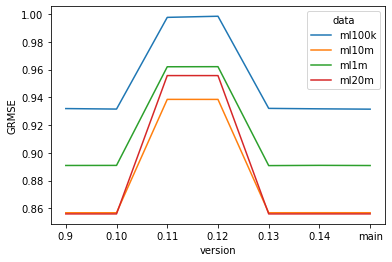

In [8]:
als = mdf[mdf['algo'] == 'ALS']
sns.lineplot(x='version', y='GRMSE', hue='data', data=als)

<AxesSubplot:xlabel='version', ylabel='nDCG'>

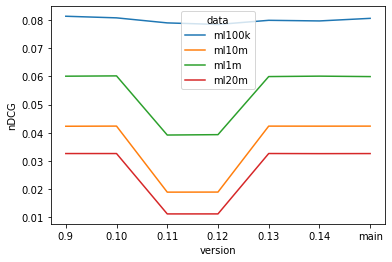

In [9]:
als = mdf[mdf['algo'] == 'ALS']
sns.lineplot(x='version', y='nDCG', hue='data', data=als)

## Item-Item Results

Now the item-item results:

<AxesSubplot:xlabel='version', ylabel='GRMSE'>

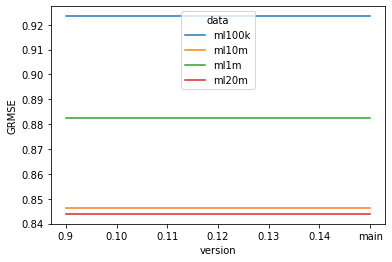

In [10]:
ii_exp = mdf[mdf['algo'] == 'II']
sns.lineplot(x='version', y='GRMSE', hue='data', data=ii_exp)

<AxesSubplot:xlabel='version', ylabel='nDCG'>

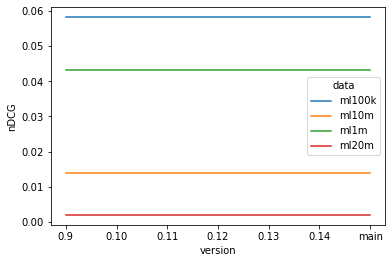

In [11]:
ii_exp = mdf[mdf['algo'] == 'II']
sns.lineplot(x='version', y='nDCG', hue='data', data=ii_exp)

## User-User Results


<AxesSubplot:xlabel='version', ylabel='GRMSE'>

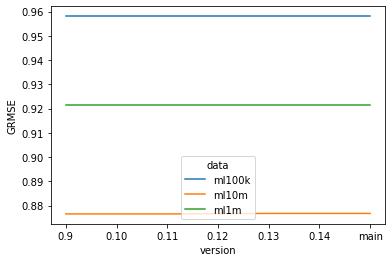

In [12]:
uu_exp = mdf[mdf['algo'] == 'UU']
sns.lineplot(x='version', y='GRMSE', hue='data', data=uu_exp)

<AxesSubplot:xlabel='version', ylabel='nDCG'>

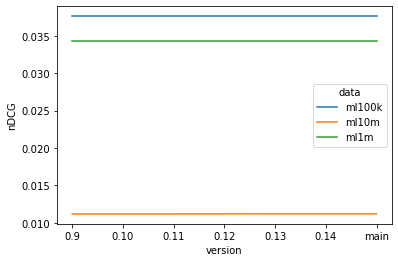

In [13]:
uu_exp = mdf[mdf['algo'] == 'UU']
sns.lineplot(x='version', y='nDCG', hue='data', data=uu_exp)

## IALS Results

Let's first look at biased MF from Implicit ALS:

<AxesSubplot:xlabel='version', ylabel='nDCG'>

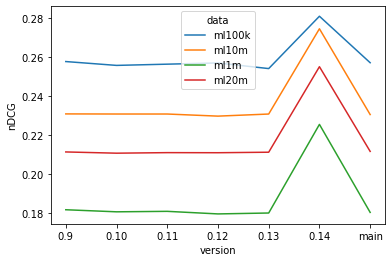

In [14]:
als = mdf[mdf['algo'] == 'IALS']
sns.lineplot(x='version', y='nDCG', hue='data', data=als)

## Combined Algorithm Results

Let's look at all the algorithms together as a point plot:

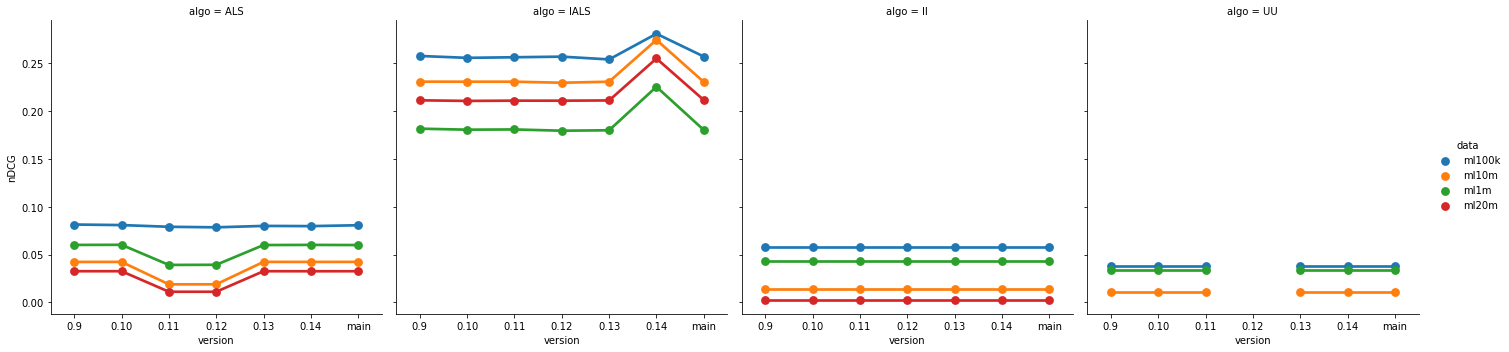

In [15]:
sns.catplot(x='version', y='nDCG', hue='data', col='algo', data=mdf, kind='point')